In [1]:
import gymnasium as gym
from adaptive_time.features import Fourier_Features
import numpy as np

import matplotlib.pyplot as plt
import random

In [2]:
seed = 13

In [3]:
gym.register(
    id="CartPole-OURS-v0",
    entry_point="adaptive_time.environments.cartpole:CartPoleEnv",
    vector_entry_point="adaptive_time.environments.cartpole:CartPoleVectorEnv",
    max_episode_steps=500,
    reward_threshold=475.0,
)

In [4]:
def reset_randomness(seed, env):
    random.seed(seed)
    np.random.seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)


In [5]:
env = gym.make('CartPole-OURS-v0')
tau = 0.02
env.stepTime(tau)


def generate_trajectory(env, policy=None):
    observation, _ = env.reset()
    trajectory = []
    terminated = False
    if policy is None:
        policy = lambda x: env.action_space.sample()
    while not terminated:
        action = policy(observation)
        observation_, reward, terminated, truncated, info = env.step(action)
        trajectory.append([observation, action, reward, observation_])
        observation = observation_

    return trajectory


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.stepTime to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.stepTime` for environment variables or `env.get_wrapper_attr('stepTime')` that will search the reminding wrappers.
  logger.warn(


In [6]:

reset_randomness(seed, env)
trajectory = generate_trajectory(env)

In [7]:
print(len(trajectory))
print(trajectory[0])

# seed = 13 should be:
# 16
# [array([0., 0., 0., 0.], dtype=float32), 1, 1.0, array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)]

16
[array([0., 0., 0., 0.], dtype=float32), 1, 1.0, array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)]


In [8]:
phi = Fourier_Features()
phi.init_fourier_features(4,4)
phi.init_state_normalizers(np.array([4.8,2.0,0.418,1]), np.array([-4.8,-2.0,-0.418,-1]))

In [55]:


def ols_monte_carlo(env, phi, weights, targets, features, x0, gamma = 0.999):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    returns = []  # from x0 (the initial state)
    for t in range(N-1,-1,-1):
        state, _, reward, _ = trajectory[t]
        G = gamma*G + reward
        x = phi.get_fourier_feature(state)
        if np.linalg.norm(x-x0) < 0.00001:
            returns.append(G)
        features += np.outer(x,x)
        targets += G * x
    weights = np.linalg.solve(features, targets)
    return weights, targets, features, np.mean(returns)


def gradient_monte_carlo(env, phi, weights, x0, gamma = 1, alpha = 0.001):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    returns = []
    for t in range(N-1,-1,-1):
        state, _, reward, _ = trajectory[t]
        G = gamma * G + reward
        x = phi.get_fourier_feature(state)
        if np.linalg.norm(x-x0) < 0.00001:
            returns.append(G)
        weights = weights + alpha * (G - np.inner(x, weights)) * x 
    return weights, np.mean(returns)




num_episodes = 1000
returns = []
average_returns = []
predicted_returns = []

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((d,d))   # An estimate of A = xx^T
targets = np.zeros(d)  # An estimate of b = xG
weights = np.zeros(d)   # The weights that approximate A^{-1} b
x = phi.get_fourier_feature([0,0,0,0])  # the initial state
for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo(
        env, phi, weights, targets, features, x)
    if cur_avr_returns:
        # When we are starting from the fixed initial state, this
        # should always be true!
        returns.append(cur_avr_returns)
    if returns:
        average_returns.append(np.mean(returns))
        pred_return = np.inner(x, weights)
        predicted_returns.append(pred_return)
        print(
            'episode:', episode,
            ' empirical returns:' , np.mean(returns),
            ' predicted returns:' , pred_return)

episode: 0  empirical returns: 15.880558184360002  predicted returns: 15.880558184360751
episode: 1  empirical returns: 16.372617905267823  predicted returns: 16.37261790526668
episode: 2  empirical returns: 18.8237497423018  predicted returns: 18.82374974234847
episode: 3  empirical returns: 24.40540453558862  predicted returns: 24.405425579316216
episode: 4  empirical returns: 22.306196228670693  predicted returns: 22.30617519034422
episode: 5  empirical returns: 22.705544757717806  predicted returns: 22.590263845399022
episode: 6  empirical returns: 21.730546675809553  predicted returns: 21.758410533424467
episode: 7  empirical returns: 21.36797398328347  predicted returns: 21.275481957825832
episode: 8  empirical returns: 20.8676077213826  predicted returns: 21.024954640306532
episode: 9  empirical returns: 20.859979352773827  predicted returns: 21.385753076523542
episode: 10  empirical returns: 21.03168688238969  predicted returns: 28.440553039312363
episode: 11  empirical returns

In [56]:
def plot_est_vs_pred(tuples_of_y_and_labels_and_kwargs, title=None, show=True):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for y, label, kwargs in tuples_of_y_and_labels_and_kwargs:
        plt.plot(y, label=label, **kwargs)

    # if ylim:
    #     plt.ylim(-0.05, 0.5)
    # ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    # plt.xlim(-1000, 80_000)

    plt.ylabel('Episode\nReturn', rotation=0, labelpad=40)
    plt.xlabel('Number of Episodes')
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax


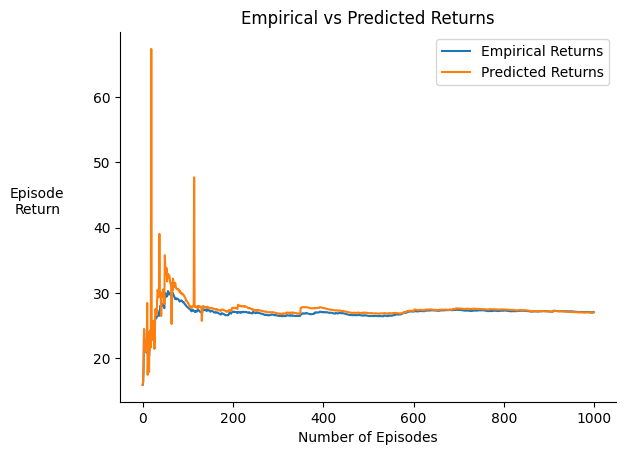

<Axes: title={'center': 'Empirical vs Predicted Returns'}, xlabel='Number of Episodes', ylabel='Episode\nReturn'>

In [57]:

plot_est_vs_pred([
   (average_returns, 'Empirical Returns', {}),
   (predicted_returns, 'Predicted Returns', {})],
   title='Empirical vs Predicted Returns')


## Q-function estimation

Like above, but now learn per-action returns. The strategy is the same, but instead of using `v(s) = phi(s)' w`, we use `q(s, a) = phi(s, a)' w`.

We'll use `phi(s, a) = [ 1_{a=0}*phi(s), 1_{a=1}*phi(s) ]`, so basically each action gets its own weights.

In [29]:
def phi_sa(phi_x, a, prev_phi_sa=None):
    """Form the (state, action) feature, potentially reusing memory.
    
    - phi_x: the state feature
    - a: the action
    - prev_phi_sa: the previous state,action feature, which can be
      reused to avoid memory allocation.

    Returns the feature as a (2, d) array. Use a flat copy.
    """
    if prev_phi_sa is not None:
        prev_phi_sa.fill(0)
        phi_sa = prev_phi_sa
    else:
        phi_sa = np.zeros((2, phi_x.size))
    phi_sa[a] = phi_x
    return phi_sa


def ols_monte_carlo_q(env, phi, weights, targets, features, x0, gamma = 0.999):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    x_sa = np.zeros((2, phi.num_parameters))
    returns_a0 = []  # from x0 (the initial state), action 0
    returns_a1 = []  # from x0 (the initial state), action 1
    for t in range(N-1,-1,-1):
        state, action, reward, _ = trajectory[t]
        G = gamma*G + reward
        x = phi.get_fourier_feature(state)
        # Record empirical returns.
        if np.linalg.norm(x-x0) < 0.00001:
            if action == 0:
                returns_a0.append(G)
            elif action == 1:
                returns_a1.append(G)

        x_sa = phi_sa(x, action, x_sa)
        x_sa_flat = x_sa.flatten()

        features += np.outer(x_sa_flat, x_sa_flat)
        targets += G * x_sa_flat
    weights = np.linalg.solve(features, targets)
    return weights, targets, features, (np.mean(returns_a0), np.mean(returns_a1))



### Run Q-function estimation

In [52]:

num_episodes = 2000

# We record:
returns_per_episode_q = np.zeros((2, num_episodes))
average_returns_q = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((2 * d, 2 * d))   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q[:, episode] = cur_avr_returns
    average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)

    predicted_returns_q[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , average_returns_q[:, episode],
        ' predicted returns:' , predicted_returns_q[:, episode])

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_47411/2627431572.py:29: RuntimeWarning: Mean of empty slice
  average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)


episode: 0  empirical returns: [        nan 15.88055818]  predicted returns: [-119.78243383   15.88055818]
episode: 1  empirical returns: [        nan 16.37261791]  predicted returns: [-63.81073968  16.37261791]
episode: 2  empirical returns: [        nan 18.82374974]  predicted returns: [-300.11604784   18.82374974]
episode: 3  empirical returns: [        nan 24.40540454]  predicted returns: [43.80909698 24.40540453]
episode: 4  empirical returns: [        nan 22.30619623]  predicted returns: [39.75635012 22.30619623]
episode: 5  empirical returns: [24.7022874  22.30619623]  predicted returns: [24.70229221 22.30620529]
episode: 6  empirical returns: [20.29142279 22.30619623]  predicted returns: [20.2913537 22.3061974]
episode: 7  empirical returns: [20.29142279 21.72682438]  predicted returns: [20.29143682 21.7268208 ]
episode: 8  empirical returns: [20.29142279 21.03223199]  predicted returns: [20.29138789 21.03223406]
episode: 9  empirical returns: [20.45805654 21.03223199]  predict

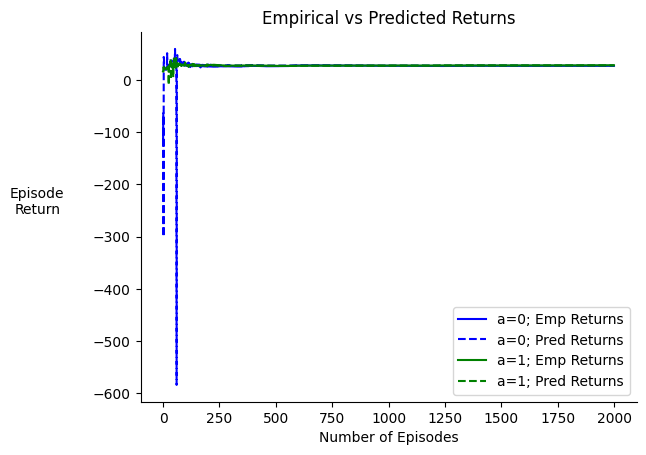

<Axes: title={'center': 'Empirical vs Predicted Returns'}, xlabel='Number of Episodes', ylabel='Episode\nReturn'>

In [53]:

plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='Empirical vs Predicted Returns',
   show=True)



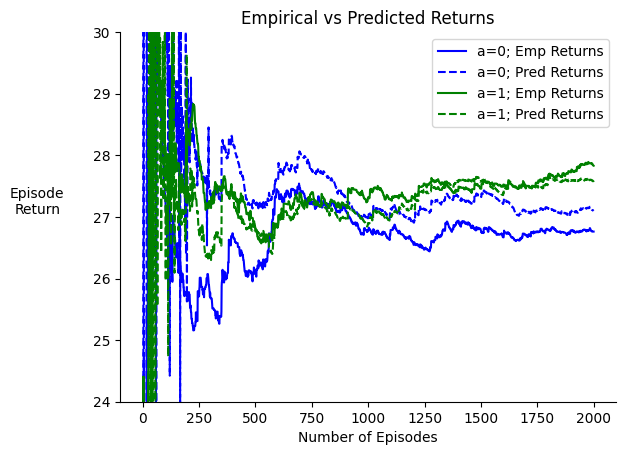

In [54]:

ax = plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='Empirical vs Predicted Returns',
   show=False)

ax.set_ylim(24, 30)
plt.show()


## Random Tests

In [17]:
testx = np.array([
    [1, 2, 3],
    [10, 20, 30]
])
print(testx)

print(testx.flatten())

[[ 1  2  3]
 [10 20 30]]
[ 1  2  3 10 20 30]


In [25]:
testy = np.array([
    [1, 0, 0],
    [np.nan, 0, 0]
])

ep = 1
testy[:, ep] = (np.nan, 20)  
print(testy)
print(np.nanmean(testy[:, :ep+1], axis=1))



[[ 1. nan  0.]
 [nan 20.  0.]]
[ 1. 20.]


In [16]:
a = testx
a.fill(0)
print(a)
print(testx)

[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]


In [20]:
if np.mean([]):
    print("mean exists")
else:
    print("mean does not exist")

mean exists


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
testx[:, 0] = (0, 0)
print(testx)

[[ 0  2  3]
 [ 0 20 30]]


In [ ]:
trajectory

[[array([1., 0., 0.], dtype=float32),
  array([1.683155], dtype=float32),
  -0.002833010554083572,
  array([0.9999203 , 0.01262333, 0.25247324], dtype=float32)],
 [array([0.9999203 , 0.01262333, 0.25247324], dtype=float32),
  array([-1.1154854], dtype=float32),
  -0.007777938334370556,
  array([0.99984944, 0.01735369, 0.09461792], dtype=float32)],
 [array([0.99984944, 0.01735369, 0.09461792], dtype=float32),
  array([-0.27207616], dtype=float32),
  -0.0012704612358089731,
  array([0.99978584, 0.02069417, 0.06682176], dtype=float32)],
 [array([0.99978584, 0.02069417, 0.06682176], dtype=float32),
  array([-1.2429843], dtype=float32),
  -0.002419834533924224,
  array([ 0.99988   ,  0.01548976, -0.10410526], dtype=float32)],
 [array([ 0.99988   ,  0.01548976, -0.10410526], dtype=float32),
  array([0.7708461], dtype=float32),
  -0.001917946138216929,
  array([0.9998614 , 0.01664656, 0.02313899], dtype=float32)],
 [array([0.9998614 , 0.01664656, 0.02313899], dtype=float32),
  array([1.530998